# Programming Assignment 2: Convolutional Neural Networks
Based on an assignment by Lisa Zhang

For CSC413/2516 in Winter 2020 with Professor Jimmy Ba

**Submission:**
You must submit two files through [MarkUs](https://markus.teach.cs.toronto.edu/csc413-2020-01): a PDF file containing your writeup, titled *a2-writeup.pdf*, and your code file *a2-cnn.ipynb*. Your writeup must be typeset.

The programming assignments are individual work. See the [Course Syllabus](https://csc413-2020.github.io/assets/misc/syllabus.pdf) for detailed policies. 

**Introduction:**  
This assignment will focus on the applications of convolutional neural networks in various image processing tasks. First, we will train a convolutional neural network for a task known as image colourization. Given a greyscale image, we will predict the colour at each pixel. This a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple,  equally valid colourings. 

In the second half of the assignment, we will perform fine-tuning on a pre-trained semantic segmentation model. Semantic segmentation attempts to clusters the areas of an image which belongs to the same object (label), and treats each pixel as a classification problem. We will fine-tune a pre-trained conv net featuring dilated convolution to segment flowers from the [Oxford17 flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/)

# Colab FAQ and Using GPU

For some basic overview and features offered in Colab notebooks, check out: [Overview of Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

You need to use the Colab GPU for this assignment by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

# Download CIFAR and Colour dictionary
We will use the [CIFAR-10 data set](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz), which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. To make the problem easier, we will only use the “Horse” category from this data set. Now let’s learn to colour some horses!

The data loading script is included below. It can take up to a couple of minutes to download everything the first time.

All files are stored at `/content/csc413/a2/data/` folder

#### Helper code
You can ignore the restart warning.

In [1]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/csc413/a2/
%cd /content/csc413/a2

######################################################################
# Helper functions for loading data
######################################################################
# adapted from 
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
from six.moves.urllib.request import urlretrieve
import tarfile
import numpy as np
import pickle
import sys
from PIL import Image


def get_file(fname,
             origin,
             untar=False,
             extract=False,
             archive_format='auto',
             cache_dir='data'):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + '.tar.gz'
    else:
        fpath = os.path.join(datadir, fname)
    
    print('File path: %s' % fpath)
    if not os.path.exists(fpath):
        print('Downloading data from', origin)

        error_msg = 'URL fetch failure on {}: {} -- {}'
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print('Extracting file.')
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath

def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, 'rb')
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding='bytes')
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode('utf8')] = v
        d = d_decoded
    f.close()
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = 'cifar-10-batches-py'
    origin = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.zeros((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000: i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000: i * 10000] = labels

    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

/content/csc413/a2


#### Download files

This may take 1 or 2 mins for the first time.

In [2]:
# Download cluster centers for k-means over colours
colours_fpath = get_file(fname='colours', 
                         origin='http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz', 
                         untar=True)
# Download CIFAR dataset
m = load_cifar10()

File path: data/colours.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz')
Extracting file.
File path: data/cifar-10-batches-py.tar.gz
('Downloading data from', 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')
Extracting file.


# Part A. Colourization as Classification (2 pts)

We will select a subset of 24 colours and frame colourization as a pixel-wise classification problem, where we label each pixel with one of 24 colours. The 24 colours are selected using [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) over colours, and selecting cluster centers. 

This was already done for you, and cluster centers are provided in http://www.cs.toronto.edu/~jba/kmeans_colour_a2.tar.gz, which was downloaded by the helper functions above. For simplicity, we will measure distance in RGB space. This is not ideal but reduces the software dependencies for this assignment.

## Helper code

In [0]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
from __future__ import print_function
import argparse
import math
import numpy as np
import numpy.random as npr
import scipy.misc
import time
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt 


#from load_data import load_cifar10

HORSE_CATEGORY = 7

#### Data related code

In [0]:
def get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This function doesn't
    actually do the work, instead it splits the work into smaller
    chunks that can fit into memory, and calls helper function
    _get_rgb_cat

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    if np.shape(xs)[0] < 100:
        return _get_rgb_cat(xs)
    batch_size = 100
    nexts = []
    for i in range(0, np.shape(xs)[0], batch_size):
        next = _get_rgb_cat(xs[i:i+batch_size,:,:,:], colours)
        nexts.append(next)
    result = np.concatenate(nexts, axis=0)
    return result

def _get_rgb_cat(xs, colours):
    """
    Get colour categories given RGB values. This is done by choosing
    the colour in `colours` that is the closest (in RGB space) to
    each point in the image `xs`. This function is a little memory
    intensive, and so the size of `xs` should not be too large.

    Args:
      xs: float numpy array of RGB images in [B, C, H, W] format
      colours: numpy array of colour categories and their RGB values
    Returns:
      result: int numpy array of shape [B, 1, H, W]
    """
    num_colours = np.shape(colours)[0]
    xs = np.expand_dims(xs, 0)
    cs = np.reshape(colours, [num_colours,1,3,1,1])
    dists = np.linalg.norm(xs-cs, axis=2) # 2 = colour axis
    cat = np.argmin(dists, axis=0)
    cat = np.expand_dims(cat, axis=1)
    return cat

def get_cat_rgb(cats, colours):
    """
    Get RGB colours given the colour categories

    Args:
      cats: integer numpy array of colour categories
      colours: numpy array of colour categories and their RGB values
    Returns:
      numpy tensor of RGB colours
    """
    return colours[cats]

def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)
    
    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                               nn.AvgPool2d(2), 
                               nn.Upsample(scale_factor=2), 
                               nn.Upsample(scale_factor=2))
      xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
      xs_downsized = xs_downsized.data.numpy()
      return (xs, xs_downsized)
    else:
      return (xs, grey)


def get_batch(x, y, batch_size):
    '''
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    '''
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i:i+batch_size, :,:,:]
        batch_y = y[i:i+batch_size, :,:,:]
        yield (batch_x, batch_y)

#### Torch helper

In [0]:
def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): categorical labels 
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).long()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def compute_loss(criterion, outputs, labels, batch_size, num_colours):
    """
    Helper function to compute the loss. Since this is a pixelwise
    prediction task we need to reshape the output and ground truth
    tensors into a 2D tensor before passing it in to the loss criteron.

    Args:
      criterion: pytorch loss criterion
      outputs (pytorch tensor): predicted labels from the model
      labels (pytorch tensor): ground truth labels
      batch_size (int): batch size used for training
      num_colours (int): number of colour categories
    Returns:
      pytorch tensor for loss
    """

    loss_out = outputs.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32, num_colours])
    loss_lab = labels.transpose(1,3) \
                      .contiguous() \
                      .view([batch_size*32*32])
    return criterion(loss_out, loss_lab)

def run_validation_step(cnn, criterion, test_grey, test_rgb_cat, batch_size,
                        colours, plotpath=None, visualize=True, downsize_input=False):
    correct = 0.0
    total = 0.0
    losses = []
    num_colours = np.shape(colours)[0]
    for i, (xs, ys) in enumerate(get_batch(test_grey,
                                           test_rgb_cat,
                                           batch_size)):
        images, labels = get_torch_vars(xs, ys, args.gpu)
        outputs = cnn(images)

        val_loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
        losses.append(val_loss.data.item())

        _, predicted = torch.max(outputs.data, 1, keepdim=True)
        total += labels.size(0) * 32 * 32
        correct += (predicted == labels.data).sum()

    if plotpath: # only plot if a path is provided
        plot(xs, ys, predicted.cpu().numpy(), colours, 
             plotpath, visualize=visualize, compare_bilinear=downsize_input)

    val_loss = np.mean(losses)
    val_acc = 100 * correct / total
    return val_loss, val_acc

#### Visualization

In [0]:
def plot(input, gtlabel, output, colours, path, visualize, compare_bilinear=False):
    """
    Generate png plots of input, ground truth, and outputs

    Args:
      input: the greyscale input to the colourization CNN
      gtlabel: the grouth truth categories for each pixel
      output: the predicted categories for each pixel
      colours: numpy array of colour categories and their RGB values
      path: output path
      visualize: display the figures inline or save the figures in path
    """
    grey = np.transpose(input[:10,:,:,:], [0,2,3,1])
    gtcolor = get_cat_rgb(gtlabel[:10,0,:,:], colours)
    predcolor = get_cat_rgb(output[:10,0,:,:], colours)

    img_stack = [
      np.hstack(np.tile(grey, [1,1,1,3])),
      np.hstack(gtcolor),
      np.hstack(predcolor)]
    
    if compare_bilinear:
      downsize_module = nn.Sequential(nn.AvgPool2d(2),
                                 nn.AvgPool2d(2), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'), 
                                 nn.Upsample(scale_factor=2, mode='bilinear'))
      gt_input = np.transpose(gtcolor, [0, 3, 1, 2,])
      color_bilinear = downsize_module.forward(torch.from_numpy(gt_input).float())
      color_bilinear = np.transpose(color_bilinear.data.numpy(), [0, 2, 3, 1])
      img_stack = [
        np.hstack(np.transpose(input[:10,:,:,:], [0,2,3,1])),
        np.hstack(gtcolor),
        np.hstack(predcolor),
        np.hstack(color_bilinear)]
    img = np.vstack(img_stack)
    
    plt.grid('off')
    plt.imshow(img, vmin=0., vmax=1.)
    if visualize:
      plt.show()
    else:
      plt.savefig(path)

def toimage(img, cmin, cmax):
    return Image.fromarray((img.clip(cmin, cmax)*255).astype(np.uint8))
  
def plot_activation(args, cnn):
    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]
    
    (x_train, y_train), (x_test, y_test) = load_cifar10()
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)
    
    # Take the idnex of the test image
    id = args.index
    outdir = "outputs/" + args.experiment_name + '/act' + str(id)
    if not os.path.exists(outdir):
      os.makedirs(outdir)
    images, labels = get_torch_vars(np.expand_dims(test_grey[id], 0),
                                    np.expand_dims(test_rgb_cat[id], 0))
    cnn.cpu()
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1, keepdim=True)
    predcolor = get_cat_rgb(predicted.cpu().numpy()[0,0,:,:], colours)
    img = predcolor
    toimage(predcolor, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "output_%d.png" % id))

    if not args.downsize_input:
      img = np.tile(np.transpose(test_grey[id], [1,2,0]), [1,1,3])
    else:
      img = np.transpose(test_grey[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d.png" % id))

    img = np.transpose(test_rgb[id], [1,2,0])
    toimage(img, cmin=0, cmax=1) \
            .save(os.path.join(outdir, "input_%d_gt.png" % id))

    
    def add_border(img):
        return np.pad(img, 1, "constant", constant_values=1.0)

    def draw_activations(path, activation, imgwidth=4):
        img = np.vstack([
            np.hstack([
                add_border(filter) for filter in
                activation[i*imgwidth:(i+1)*imgwidth,:,:]])
            for i in range(activation.shape[0] // imgwidth)])
        scipy.misc.imsave(path, img)


    for i, tensor in enumerate([cnn.out1, cnn.out2, cnn.out3, cnn.out4, cnn.out5]):
        draw_activations(
            os.path.join(outdir, "conv%d_out_%d.png" % (i+1, id)),
            tensor.data.cpu().numpy()[0])
    print("visualization results are saved to %s"%outdir)

#### Training

In [0]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    #TODO: necessary?
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    
    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE COLOURS CATEGORIES
    colours = np.load(args.colours, allow_pickle=True)[0]
    num_colours = np.shape(colours)[0]
    # INPUT CHANNEL
    num_in_channels = 1 if not args.downsize_input else 3
    # LOAD THE MODEL
    if cnn is None:
      if args.model == "CNN":
          cnn = CNN(args.kernel, args.num_filters, num_colours, num_in_channels)
      elif args.model == "UNet":
          cnn = UNet(args.kernel, args.num_filters, num_colours, num_in_channels)

    # LOSS FUNCTION
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input = args.downsize_input)
    train_rgb_cat = get_rgb_cat(train_rgb, colours)
    test_rgb, test_grey = process(x_test, y_test, downsize_input = args.downsize_input)
    test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu: cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train() # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey,
                                               train_rgb_cat,
                                               args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = cnn(images)

            loss = compute_loss(criterion,
                                outputs,
                                labels,
                                batch_size=args.batch_size,
                                num_colours=num_colours)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            _, predicted = torch.max(outputs.data, 1, keepdim=True)
            plot(xs, ys, predicted.cpu().numpy(), colours,
                 save_dir+'/train_%d.png' % epoch, 
                 args.visualize, 
                 args.downsize_input)

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
            epoch+1, args.epochs, avg_loss, time_elapsed))

        # Evaluate the model
        cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
        val_loss, val_acc = run_validation_step(cnn,
                                                criterion,
                                                test_grey,
                                                test_rgb_cat,
                                                args.batch_size,
                                                colours,
                                                save_dir+'/test_%d.png' % epoch,
                                                args.visualize,
                                                args.downsize_input)

        time_elapsed = time.time() - start
        valid_losses.append(val_loss)
        valid_accs.append(val_acc)
        print('Epoch [%d/%d], Val Loss: %.4f, Val Acc: %.1f%%, Time(s): %.2f' % (
            epoch+1, args.epochs, val_loss, val_acc, time_elapsed))
    
    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    if args.checkpoint:
        print('Saving model...')
        torch.save(cnn.state_dict(), args.checkpoint)
    
    return cnn



```
# This is formatted as code
```

## Question 1.
<!-- Complete the model CNN below. This model should have the same layers and convolutional filters as the RegressionCNN, with the exception of the output layer.  -->

Complete the CNN model following the architecture described in the assignment handout.

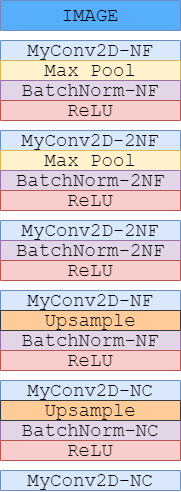

In the diagram, we denote the number of filters as **NF**. Further layers double the number of filters, denoted as **2NF**. In the final layers, the number of filters will be equivalent to the number of colour classes, denoted as **NC**. Consequently, your constructed neural network should define the number of input/output layers with respect to the variables `num_filters` and `num_colours`, as opposed to a constant value.


We will use our own convolution module MyConv2d instead of PyTorch's nn.Conv2D to better understand its internals.  
Each MyConv2d layer should be parameterized as follows:
- The number of channels in the image is defined in `num_in_channels`. Use this as the number of input filters for the first convolution.
- The number of output filters for each MyConv2d layer is specified after the hyphen. 
- The kernel size used in MyConv2d should be specified via the `kernel` parameter.


For the remaining operations, you may use the default PyTorch implementations.  
The specific modules to use are listed below. If parameters are not otherwise specified, use the default PyTorch parameters.

- [nn.MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d): Use `kernel_size=2` for all layers.

- [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d): The number of features is specified after the hyphen in the diagram as a multiple of **NF** or **NC**.

- [nn.Upsample](https://pytorch.org/docs/stable/nn.html#upsample): Use `scaling_factor=2` for all layers.

- [nn.ReLU](https://pytorch.org/docs/stable/nn.html#relu)


We recommend grouping each block of operations (those adjacent without whitespace in the diagram) into [nn.Sequential](https://pytorch.org/docs/stable/nn.html#sequential) containers.  
Grouping up relevant operations will allow for easier implementation of the `forward` method.

In [0]:
######################################################################
# MODELS
######################################################################

class MyConv2d(nn.Module):
    """
    Our simplified implemented of nn.Conv2d module for 2D convolution
    """
    def __init__(self, in_channels, out_channels, kernel_size, padding=None):
        super(MyConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
        self.weight = nn.parameter.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.parameter.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels * self.kernel_size * self.kernel_size
        stdv = 1. / math.sqrt(n)
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, padding=self.padding)


class CNN(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(CNN, self).__init__()
        padding = kernel // 2

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        self.kernel = kernel
        self.num_filters = num_filters
        self.num_colours = num_colours
        self.num_in_channels = num_in_channels
        # First conv, 32 * 32 * 1NF
        self.layer1 = nn.Sequential(
            MyConv2d(self.num_in_channels, self.num_filters, kernel_size=self.kernel, padding=padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(self.num_filters),
            nn.ReLU())
        # Second Conv, 16 * 16 * 2NF
        self.layer2 =  nn.Sequential(
            MyConv2d(self.num_filters, self.num_filters * 2, self.kernel, padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(self.num_filters*2),
            nn.ReLU())
        # Third conv, 8 * 8 * 2NF
        self.layer3 = nn.Sequential(
            MyConv2d(self.num_filters * 2, self.num_filters * 2, self.kernel, padding),
            nn.BatchNorm2d(self.num_filters * 2),
            nn.ReLU())
        # Fourth conv, 8 * 8 * 1NF
        self.layer4 = nn.Sequential(
            MyConv2d(self.num_filters * 2, self.num_filters, self.kernel, padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(self.num_filters),
            nn.ReLU())
        # Fifth conv, 16 * 16 * 1NC
        self.layer5 = nn.Sequential(
            MyConv2d(num_filters, self.num_colours, self.kernel, padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(self.num_colours),
            nn.ReLU())
        # Final Conv, 32 * 32 * 1NC
        self.layer6 = MyConv2d(self.num_colours, self.num_colours, self.kernel)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        self.output1 = self.layer1(x)
        self.output2 = self.layer2(self.output1)
        self.output3 = self.layer3(self.output2)
        self.output4 = self.layer4(self.output3)
        self.output5 = self.layer5(self.output4)
        self.output6 = self.layer6(self.output5)
        return self.output6

## Question 2.
Run main training loop of CNN in colourization.ipynb on Colab. This will train a CNN for a few epochs using the cross-entropy objective. It will generate some images showing the trained result at the end. Do these results look good to you? Why or why not?

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 3.3535, Time (s): 0
Epoch [1/25], Val Loss: 3.1885, Val Acc: 8.6%, Time(s): 1.10
Epoch [2/25], Loss: 3.0627, Time (s): 1
Epoch [2/25], Val Loss: 3.0618, Val Acc: 10.3%, Time(s): 2.11
Epoch [3/25], Loss: 2.9101, Time (s): 2
Epoch [3/25], Val Loss: 2.9877, Val Acc: 13.4%, Time(s): 3.13
Epoch [4/25], Loss: 2.6104, Time (s): 3
Epoch [4/25], Val Loss: 2.8412, Val Acc: 15.4%, Time(s): 4.18
Epoch [5/25], Loss: 2.4439, Time (s): 5
Epoch [5/25], Val Loss: 2.4535, Val Acc: 17.8%, Time(s): 5.24
Epoch [6/25], Loss: 2.3530, Time (s): 6
Epoch [6/25], Val Loss: 2.3473, Val Acc: 21.4%, Time(s): 6.32
Epoch [7/25], Loss: 2.3033, Time (s): 7
Epoch [7/25], Val Loss: 2.2011, Val Acc: 24.3%, Time(s): 7.43
Epoch [8/25], Loss: 2.2218, Time (s): 8
Epoch [8/25], Val Loss: 2.1755, Val Acc: 25.7%, Time(s): 8.56
Epoch [9/25], Loss: 2.2021, Time (s): 9
Epoch [9/25], Val Loss: 2.2210, Val Acc: 2

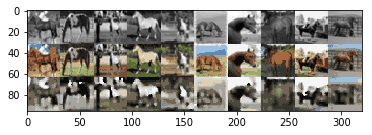

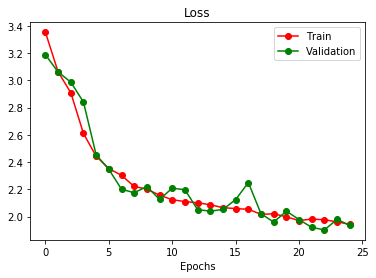

In [47]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"CNN", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.3, 
              'batch_size':100, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_cnn',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
cnn = train(args)

## Question 3.

Compute the number of weights, outputs, and connections in the model, as a function of **NF** and **NC**. Compute these values when each input dimension (width/height) is doubled. Report all 6 values.  

## Question 4.

 Consider an pre-processing step where each input pixel is multiplied elementwise by scalar $a$, and is shifted by some scalar $b$. That is, where the original pixel value is denoted $x$, the new value is calculated $y = ax + b$. Assume this operation does not result in any overflows. How does this pre-processing step affect the output of the conv net from Question 1 and 2?

# Part B. Skip Connections (2 pts)


A skip connection in a neural network is a connection which skips one or more layer and connects
to a later layer. We will introduce skip connections to our previous model.

## Question 1.
In this question, we will be adding a skip connection from the first layer to the last, second layer to the second last, etc. That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection is introduced by [Ronneberger et al.[2015]](https://arxiv.org/abs/1505.04597), and is called a ”UNet”. 

Just like the `CNN` class that you have completed in the previous part, complete the `__init__` and `forward` methods methods of the `UNet` class below.

Hint: You will need to use the function `torch.cat`.

In [0]:
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super(UNet, self).__init__()
        
        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        padding = kernel // 2
        
        self.layer1 = nn.Sequential(
            MyConv2d(num_in_channels, num_filters, kernel, padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())
        
        self.layer2 = nn.Sequential(
            MyConv2d(num_filters, num_filters * 2,  kernel, padding),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())
        
        self.layer3 = nn.Sequential(
            MyConv2d(num_filters * 2, num_filters * 2, kernel, padding),
            nn.BatchNorm2d(num_filters * 2),
            nn.ReLU())
        
        self.layer4 = nn.Sequential(
            MyConv2d(4 * num_filters, num_filters, kernel, padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(num_filters),
            nn.ReLU())
        
        self.layer5 = nn.Sequential(
            MyConv2d(2 * num_filters, num_colours, kernel, padding),
            nn.Upsample(scale_factor = 2),
            nn.BatchNorm2d(num_colours),
            nn.ReLU())
        
        self.layer6 = MyConv2d(num_colours + num_in_channels, num_colours, kernel)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ############### 
        ###################################################
        self.output1 = self.layer1(x)
        self.output2 = self.layer2(self.output1)
        self.output3 = self.layer3(self.output2)
        self.output4 = self.layer4(torch.cat((self.output2, self.output3), 1))
        self.output5 = self.layer5(torch.cat((self.output1, self.output4), 1))
        self.final_output = self.layer6(torch.cat((self.output5, x), 1))
        return self.final_output

## Question 2. 
Train the ”UNet” model for at least 25 epochs and plot the training curve using a batch size of 100. 

#### Main training loop for UNet

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
Epoch [1/25], Loss: 1.9657, Time (s): 3
Epoch [1/25], Val Loss: 1.6661, Val Acc: 39.3%, Time(s): 3.53
Epoch [2/25], Loss: 1.7251, Time (s): 6
Epoch [2/25], Val Loss: 1.5459, Val Acc: 43.1%, Time(s): 7.10
Epoch [3/25], Loss: 1.6439, Time (s): 10
Epoch [3/25], Val Loss: 1.4803, Val Acc: 45.3%, Time(s): 10.67
Epoch [4/25], Loss: 1.5856, Time (s): 13
Epoch [4/25], Val Loss: 1.4360, Val Acc: 47.0%, Time(s): 14.28
Epoch [5/25], Loss: 1.5389, Time (s): 17
Epoch [5/25], Val Loss: 1.4034, Val Acc: 48.0%, Time(s): 17.87
Epoch [6/25], Loss: 1.4976, Time (s): 21
Epoch [6/25], Val Loss: 1.3769, Val Acc: 48.8%, Time(s): 21.40
Epoch [7/25], Loss: 1.4581, Time (s): 24
Epoch [7/25], Val Loss: 1.3558, Val Acc: 49.4%, Time(s): 25.06
Epoch [8/25], Loss: 1.4191, Time (s): 28
Epoch [8/25], Val Loss: 1.3418, Val Acc: 49.6%, Time(s): 28.79
Epoch [9/25], Loss: 1.3842, Time (s): 32
Epoch [9/25], Val Loss: 1.33

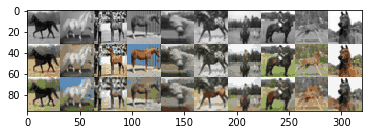

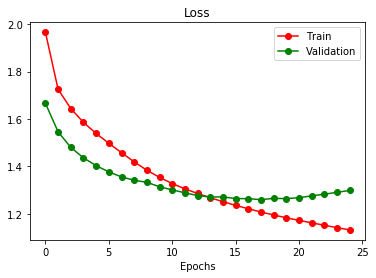

In [52]:
args = AttrDict()
args_dict = {
              'gpu':True, 
              'valid':False, 
              'checkpoint':"", 
              'colours':'./data/colours/colour_kmeans24_cat7.npy', 
              'model':"UNet", 
              'kernel':3,
              'num_filters':32, 
              'learn_rate':0.001, 
              'batch_size':10, 
              'epochs':25, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'colourization_unet',
              'visualize': False,
              'downsize_input':False,
}
args.update(args_dict)
unet_cnn = train(args)

## Question 3.
How does the result compare to the previous model? Did skip connections improve the validation loss and accuracy? Did the skip connections improve the output qualitatively? How? Give at least two reasons why skip connections might improve the performance of our CNN models.

## Question 4.
Re-train a few more ”UNet” models using different mini batch sizes with a fixed number of epochs. Describe the effect of batch sizes on the training/validation loss, and the final image output.

# Part C. Finetune Semantic Segmentation Model (2 pts)

In the previous two parts, we worked on training models for image colourization. Now we will switch gears and perform semantic segmentation by fine-tuning a pre-trained model. 
        
*Semantic segmentation* can be considered as a pixel-wise classification problem where we need to predict the class label for each pixel. Fine-tuning is often used when you only have limited labeled data.
        
Here, we take a pre-trained model on the [Microsoft COCO dataset](https://arxiv.org/abs/1405.0312) and fine-tune it to perform segmentation with the classes it was never trained on. To be more specific, we use [**deeplabv3**](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/) pre-trained model and fine-tune it on the Oxford17 flower dataset.
        
We simplify the task to be a binary semantic segmentation task (background and flower). In the following code, you will first see some examples from the Oxford17 dataset and load the finetune the model by truncating the last layer of the network and replacing it with a randomly initialized convolutional layer. Note that we only update the weights of the newly introduced layer.


## Helper code
Below helper functions are provided for setting up the dataset and visualization.

In [0]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

### Data related code

In [0]:
# Dataset helper function
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

def denormalize(img):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img*imagenet_stats[1] + imagenet_stats[0]

# Mainly imported from https://colab.research.google.com/drive/1KzGRSNQpP4BonRKj3ZwGMTGdi-e2y8z-?authuser=1#scrollTo=U_g_Rq1cA1Xi
class CUB(Dataset):
    def __init__(self, files_path, split, train=True):
      
        self.files_path = files_path
        self.split = split
        if train:
            filenames = list(self.split['trn1'][0]) + list(self.split['trn2'][0]) + list(self.split['trn3'][0])
        else:
            # We only use `val1` for validation
            filenames = self.split['val1'][0]
        
        valid_filenames = []
        for i in filenames:
            img_name = 'image_%04d.jpg' % int(i)
            if os.path.exists(os.path.join(files_path, 'jpg', img_name)) and \
                os.path.exists(os.path.join(files_path, 'trimaps', img_name.replace('jpg', 'png'))):
                valid_filenames.append(img_name)

        self.valid_filenames = valid_filenames
        self.num_files = len(valid_filenames)
       
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        
        filename = self.valid_filenames[index]

        # Load the image
        path = os.path.join(self.files_path, 'jpg', filename)
        x = read_image(path)  # H*W*c
        x = cv2.resize(x, (224,224))
        x = normalize(x)
        x = np.rollaxis(x, 2) # To meet torch's input specification(c*H*W) 

        # Load the segmentation mask
        path = os.path.join(self.files_path, 'trimaps', filename.replace("jpg", "png"))
        y = read_image(path)
        y = cv2.resize(y, (224,224))  # H*W*c
        
        return x, y

def initialize_loader(train_batch_size=64, val_batch_size=64):
    split = loadmat("datasplits.mat")
    train_dataset = CUB('./', split, train= True)
    valid_dataset = CUB('./', split, train= False)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=val_batch_size, num_workers=4)
    return train_loader, valid_loader

### Visualization

In [0]:
def visualize_dataset(dataloader):
    """Imshow for Tensor."""
    x, y = next(iter(dataloader))
    
    fig = plt.figure(figsize=(10, 5))
    for i in range(4):
      inp = x[i]
      inp = inp.numpy().transpose(1,2,0)
      inp = denormalize(inp)
      mask = y[i] / 255.
      
      ax = fig.add_subplot(2, 2, i+1, xticks=[], yticks=[])
      plt.imshow(np.concatenate([inp, mask], axis=1))

def plot_prediction(args, model, is_train, index_list=[0], plotpath=None, title=None):

    train_loader, valid_loader = initialize_loader()
    loader = train_loader if is_train else valid_loader

    images, masks = next(iter(loader))
    images = images.float()
    if args.gpu:
        images = images.cuda()

    with torch.no_grad():
        outputs = model(images)['out']
    output_predictions = outputs.argmax(1)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    colors = [i for color in colors for i in color]

    for index in index_list:
        
        r = Image.fromarray(output_predictions[index].byte().cpu().numpy())
        r.putpalette(colors)

        fig = plt.figure(figsize=(10, 5))
        if title: plt.title(title)

        ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
        plt.imshow(denormalize(images[index].cpu().numpy().transpose(1,2,0)))

        ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
        plt.imshow(r)

        ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
        plt.imshow(masks[index])

        if plotpath:
            plt.savefig(plotpath)
            plt.close()

## Download dataset and initialize DataLoader
Download the [Oxford17 Flower](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/) by running the code below. It will takes around 1 minutes for the first time.



In [56]:
import os
if not os.path.exists("17flowers.tgz"):
    print("Downloading flower dataset")
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
    !tar xvzf 17flowers.tgz
if not os.path.exists("trimaps.tgz"):
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/trimaps.tgz
    !tar xvzf trimaps.tgz
if not os.path.exists("datasplits.mat"):
    !wget https://www.robots.ox.ac.uk/~vgg/data/flowers/17/datasplits.mat

--2020-02-27 01:59:02--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/x-gzip]
Saving to: ‘17flowers.tgz’

17flowers.tgz       100%[===================>]  57.48M  21.6MB/s    in 2.7s    

2020-02-27 01:59:05 (21.6 MB/s) - ‘17flowers.tgz’ saved [60270631/60270631]

jpg/files.txt
jpg/files.txt~
jpg/image_0001.jpg
jpg/image_0002.jpg
jpg/image_0003.jpg
jpg/image_0004.jpg
jpg/image_0005.jpg
jpg/image_0006.jpg
jpg/image_0007.jpg
jpg/image_0008.jpg
jpg/image_0009.jpg
jpg/image_0010.jpg
jpg/image_0011.jpg
jpg/image_0012.jpg
jpg/image_0013.jpg
jpg/image_0014.jpg
jpg/image_0015.jpg
jpg/image_0016.jpg
jpg/image_0017.jpg
jpg/image_0018.jpg
jpg/image_0019.jpg
jpg/image_0020.jpg
jpg/image_0021.jpg
jpg/image_0022.jpg
jpg/image_0023.jpg
jpg/image_0024.

Run the code below to initialize `DataLoader` and visualize few examples 

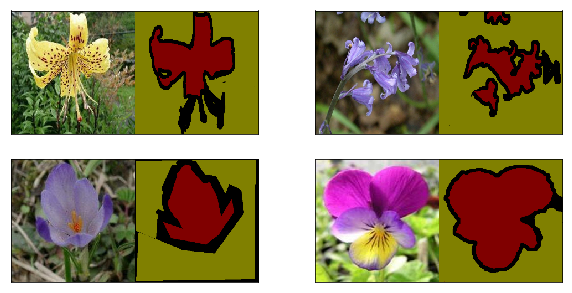

In [57]:
train_loader, valid_loader = initialize_loader()
visualize_dataset(train_loader)

## Load pre-trained model
Pytorch [Hub](https://pytorch.org/docs/stable/hub.html) supports publishing pre-trained models(model definitions and pre-trained weights) to a github repository by adding a simple hubconf.py file. Run the code below to download [deeplabv3](https://arxiv.org/pdf/1706.05587.pdf).

In [58]:
# For further details, please refer to: https://arxiv.org/pdf/1706.05587.pds
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
/root/.cache/torch/hub/pytorch_vision_v0.5.0/hubconf.py:4: RuntimeWarning: Parent module 'hubconf' not found while handling absolute import
  from torchvision.models.alexnet import alexnet
/root/.cache/torch/hub/pytorch_vision_v0.5.0/hubconf.py:5: RuntimeWarning: Parent module 'hubconf' not found while handling absolute import
  from torchvision.models.densenet import densenet121, densenet169, densenet201, densenet161
/root/.cache/torch/hub/pytorch_vision_v0.5.0/hubconf.py:6: RuntimeWarning: Parent module 'hubconf' not found while handling absolute import
  from torchvision.models.inception import inception_v3
/root/.cache/torch/hub/pytorch_vision_v0.5.0/hubconf.py:7: RuntimeWarning: Parent module 'hubconf' not found while handling absolute import
  from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152,\
/root/.cache/torch/hub/pytorch_vision_v0.5.0

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth



DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

## Helper functions for training
Below are few functions helpful for model training.

In [0]:
def compute_loss(pred, gt):
    loss = F.cross_entropy(pred, gt)
    return loss

# from https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
def iou_pytorch(outputs, labels):
    
    SMOOTH = 1e-6
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = torch.argmax(outputs, 1)
    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch

def convert_to_binary(masks, thres=0.5):
    binary_masks = ((masks[:, 0, :, :] ==  128) & (masks[:, 1, :, :] == 0) & (masks[:, 2, :, :] == 0)) + 0.
    return binary_masks.long()

def run_validation_step(args, epoch, model, loader, plotpath=None):

    model.eval()  # Change model to 'eval' mode (BN uses moving mean/var).

    losses = []
    ious = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            permute_masks = masks.permute(0, 3, 1, 2)  # to match the input size: B, C, H, W
            binary_masks = convert_to_binary(permute_masks)
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()
            output = model(images.float())
            pred_seg_masks = output["out"]

            output_predictions = pred_seg_masks[0].argmax(0)
            loss = compute_loss(pred_seg_masks, binary_masks)
            iou = iou_pytorch(pred_seg_masks, binary_masks)
            losses.append(loss.data.item())
            ious.append(iou.data.item())

        val_loss = np.mean(losses)
        val_iou = np.mean(ious)
    
    if plotpath:
        plot_prediction(args, model, False, index_list=[0], plotpath=plotpath, title='Val_%d' % epoch)
    
    return val_loss, val_iou

## Question 1.
For this assignment, we want to fine-tune only the last layer in our downloaded deeplabv3. We do this by keeping track of weights we want to update in `learned_parameters`. 
            
Use the PyTorch utility [`Model.named_parameters()`](https://pytorch.org/docs/stable/nn.html), which returns an iterator over all the weight matrices of the model. 

The last layer weights have names prefix `classifier.4`. We will select the corresponding weights then passing them to `learned_parameters`.  
            
Complete the `train` function in Part C of the notebook by adding 2-3 lines of code where indicated.


In [0]:
def train(args, model):
    
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    np.random.seed(args.seed)
    
    # Save directory
    # Create the outputs folder if not created already
    save_dir = "outputs/" + args.experiment_name
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    learned_parameters = []
    # We only learn the last layer and freeze all the other weights 
    ################ Code goes here ######################
    # Around 2-3 lines of code
    for name, parameter in model.named_parameters():
        if name.startswith('classifier.4'): learned_parameters.append(parameter)
    ######################################################

    # Adam only updates learned_parameters
    optimizer = torch.optim.Adam(learned_parameters, lr=args.learn_rate)

    train_loader, valid_loader = initialize_loader(args.train_batch_size, args.val_batch_size)
    print("Train set: {}, Test set: {}".format(
            train_loader.dataset.num_files, valid_loader.dataset.num_files))

    print("Beginning training ...")
    if args.gpu: 
        model.cuda()

    start = time.time()
    trn_losses = []
    val_losses = []
    val_ious = []
    best_iou = None

    for epoch in range(args.epochs):

        # Train the Model
        model.train() # Change model to 'train' mode
        start_tr = time.time()
        
        losses = []
        for i, (images, masks) in enumerate(train_loader):
            permute_masks = masks.permute(0, 3, 1, 2)       # to match the input size: B, C, H, W
            binary_masks = convert_to_binary(permute_masks) # B, H, W
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            output = model(images.float())
            pred_seg_masks = output["out"]

            _, pred_labels = torch.max(pred_seg_masks, 1, keepdim=True)
            loss = compute_loss(pred_seg_masks, binary_masks)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            plot_prediction(args, model, True, index_list=[0], plotpath=save_dir+'/train_%d.png' % epoch, title='Train_%d' % epoch)

        # plot training images
        trn_loss = np.mean(losses)
        trn_losses.append(trn_loss)
        time_elapsed = time.time() - start_tr
        print('Epoch [%d/%d], Loss: %.4f, Time (s): %d' % (
                epoch+1, args.epochs, trn_loss, time_elapsed))

        # Evaluate the model
        start_val = time.time()
        val_loss, val_iou = run_validation_step(args, 
                                                epoch, 
                                                model,
                                                valid_loader, 
                                                save_dir+'/val_%d.png' % epoch)

        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), os.path.join(save_dir, args.checkpoint_name + '-best.ckpt'))

        time_elapsed = time.time() - start_val
        print('Epoch [%d/%d], Loss: %.4f, mIOU: %.4f, Validation time (s): %d' % (
                epoch+1, args.epochs, val_loss, val_iou, time_elapsed))
        
        val_losses.append(val_loss)
        val_ious.append(val_iou)

    # Plot training curve
    plt.figure()
    plt.plot(trn_losses, "ro-", label="Train")
    plt.plot(val_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/training_curve.png")

    # Plot validation iou curve
    plt.figure()
    plt.plot(val_ious, "ro-", label="mIOU")
    plt.legend()
    plt.title("mIOU")
    plt.xlabel("Epochs")
    plt.savefig(save_dir+"/val_iou_curve.png")

    print('Saving model...')
    torch.save(model.state_dict(), os.path.join(save_dir, args.checkpoint_name + '-{}-last.ckpt'.format(args.epochs)))

    print('Best model achieves mIOU: %.4f' % best_iou)

## Question 2.
For fine-tuning we also want to 
* use `Model.requires_grad_()` to prevent back-prop through all the layers that should be frozen
* replace the last layer with a new `nn.Conv2d` with appropriate input output channels and kernel sizes. Since we are performing binary segmentation for this assignment, this new layer should have 2 output channels.

Complete the script below by adding around 2 lines of code and train the model.

Train set: 1280, Test set: 212
Beginning training ...
Epoch [1/10], Loss: 0.8412, Time (s): 43
Epoch [1/10], Loss: 0.6008, mIOU: 0.0991, Validation time (s): 13
Epoch [2/10], Loss: 0.4857, Time (s): 45
Epoch [2/10], Loss: 0.4198, mIOU: 0.1892, Validation time (s): 13
Epoch [3/10], Loss: 0.3771, Time (s): 48
Epoch [3/10], Loss: 0.3315, mIOU: 0.2307, Validation time (s): 13
Epoch [4/10], Loss: 0.3348, Time (s): 46
Epoch [4/10], Loss: 0.3110, mIOU: 0.2462, Validation time (s): 13
Epoch [5/10], Loss: 0.3190, Time (s): 47
Epoch [5/10], Loss: 0.3000, mIOU: 0.2835, Validation time (s): 13
Epoch [6/10], Loss: 0.3055, Time (s): 47
Epoch [6/10], Loss: 0.2820, mIOU: 0.3255, Validation time (s): 13
Epoch [7/10], Loss: 0.2957, Time (s): 48
Epoch [7/10], Loss: 0.2768, mIOU: 0.3212, Validation time (s): 12
Epoch [8/10], Loss: 0.2911, Time (s): 46
Epoch [8/10], Loss: 0.2766, mIOU: 0.3458, Validation time (s): 13
Epoch [9/10], Loss: 0.2884, Time (s): 47
Epoch [9/10], Loss: 0.2688, mIOU: 0.3255, Validat

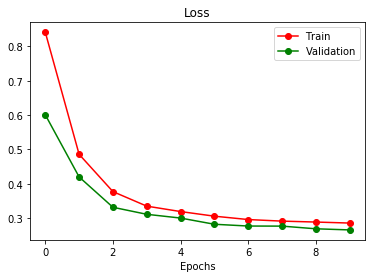

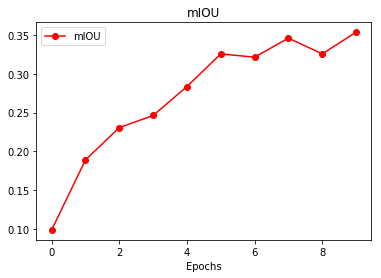

In [62]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict()
#You can play with the hyperparameters here, but to finish the assignment, 
#there is no need to tune the hyperparameters here.
args_dict = {
              'gpu':True, 
              'checkpoint_name':"finetune-segmentation", 
              'learn_rate':0.05, 
              'train_batch_size':128, 
              'val_batch_size': 256, 
              'epochs':10, 
              'seed':0,
              'plot':True, 
              'experiment_name': 'finetune-segmentation',
}
args.update(args_dict)

#Truncate the last layer and replace it with the new one.
#To avoid `CUDA out of memory` error, you might find it useful (sometimes required) 
#   to set the `requires_grad`=False for some layers
################ Code goes here ######################
# Around 2 lines of code
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))
model.requires_grad_(False)
model.classifier[4].requires_grad_(True)
######################################################

# Clear the cache in GPU
torch.cuda.empty_cache()
train(args, model)

## Question 3.
Visualize predictions by running the code below.

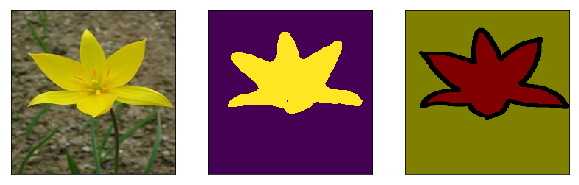

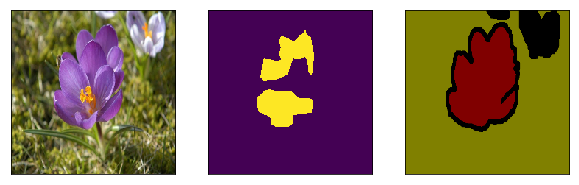

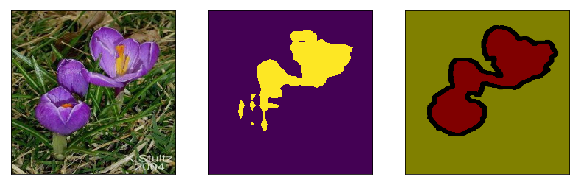

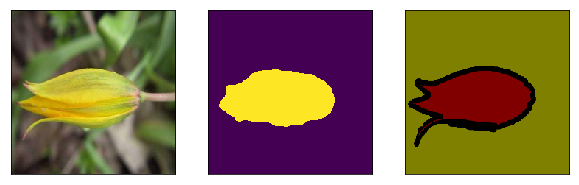

In [63]:
plot_prediction(args, model, is_train=True, index_list=[0, 1, 2, 3])

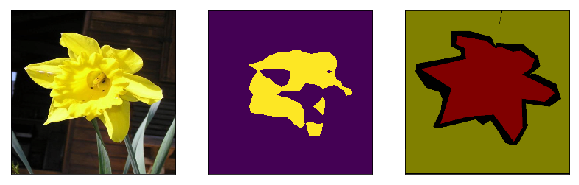

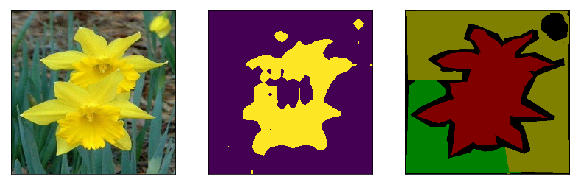

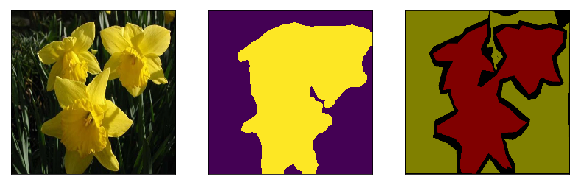

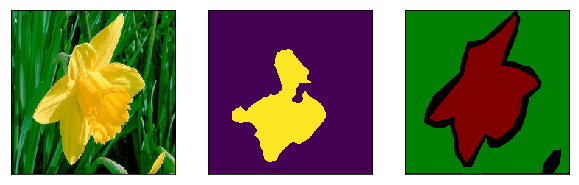

In [64]:
plot_prediction(args, model, is_train=False, index_list=[0, 1, 2, 3])

## Question 4.

Consider a case of fine-tuning a pre-trained model with *n* number of layers. Each layers have the similar number of parameters, so the total number of parameters for the model is proportional to *n*. Describe the difference in memory complexity in terms of *n* between fine-tuning an entire pre-trained model versus fine-tuning only the last layer (freezing all the other layers). What about the computational complexity? 

## Question 5.

If we increase the height and the width of the input image by a factor of 2, how does this affect the memory complexity of fine-tuning? What about the number of parameters? 